# Multisession registration with CaImAn

This notebook will help to demonstrate how to use CaImAn on movies recorded in multiple sessions. CaImAn has in-built functions that align movies from two or more sessions and try to recognize components that are imaged in some or all of these recordings.

The basic function for this is `caiman.base.rois.register_ROIs()`. It takes two sets of spatial components and finds components present in both using an intersection over union metric and the Hungarian algorithm for optimal matching.
`caiman.base.rois.register_multisession()` takes a list of spatial components, aligns sessions 1 and 2, keeps the union of the matched and unmatched components to register it with session 3 and so on.

In [40]:
from IPython import get_ipython
from matplotlib import pyplot as plt
import numpy as np
import h5py
import glob
import pims_nd2
import pandas as pd
from collections import OrderedDict
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import os

from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.utils.utils import download_demo
import sys
sys.path.append('..')
from placecode.cross_registration_functions import CellTrackingSingleAnimal as celltrack

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


loading the files and trying to make everything automatic

In [41]:
animal='OPI2356'
conditions=['novel_belt_d1','novel_belt_d2','novel_belt_d3']
conditions=['bl_d1','bl_d2','24h_post']

In [42]:
# Load multisession data (spatial components and mean intensity templates) (should be replaced by actual data)
home_folder=f'D:/sd_project_pbox/exported_data/{animal}/'
raw_data_folder=f'D:/sd_project_pbox/raw_data/{animal}'
output_folder=f'D:/sd_project_pbox/results/{animal}/'

files_list=[]
templates_list=[]
cnmf_list=[]
spatials=[]
dims=[]
# spatials=[cnmf_1.estimates.A,cnmf_2.estimates.A,cnmf_3.estimates.A]
# dims=cnmf_1.dims

for condition in conditions:

    #finding file paths
    fpath= glob.glob(f"{home_folder}/{animal}_{condition}/*.hdf5")[0]
    files_list.append(fpath)

    #sstoring cnfs
    cnmf_ind=cnmf.load_CNMF(fpath,'r')
    cnmf_list.append(cnmf_ind)
    #sotring spatial components
    spatial=cnmf_ind.estimates.A
    spatials.append(spatial)
    #storing dims
    dim=cnmf_ind.dims
    dims.append(dim)

    #template paths
    # template_path=glob.glob(f"{raw_data_folder}/*{condition}/*.nd2")[0]
    # nikon_movie=pims_nd2.ND2_Reader(template_path)
    # template=np.mean(nikon_movie[:600],axis=0)
    # templates_list.append(template)


In [43]:
from matplotlib.colors import LinearSegmentedColormap

In [44]:
# cmap = LinearSegmentedColormap.from_list('custom_cmap', ['black', 'red'], N=2)

# plt.imshow(template3,cmap=cmap)

## Use `register_multisession()`

The function `register_multisession()` requires 3 arguments:
- `A`: A list of ndarrays or scipy.sparse.csc matrices with (# pixels X # component ROIs) for each session
- `dims`: Dimensions of the FOV, needed to restore spatial components to a 2D image
- `templates`: List of ndarray matrices of size `dims`, template image of each session

In [45]:
spatial_union, assignments, matchings = register_multisession(A=spatials, dims=dims[0],max_dist=10)#, templates=templates)

c:\Users\ttami\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



finding cells that were cross registered only for two sessions
dictionary is based on the first group that I am comparing two

In [46]:
cr_reg_cells_two_ses=OrderedDict()
df=pd.DataFrame(data=assignments,columns=conditions)
for i,condition in enumerate(conditions[:-1]):
    df_per_sessions=df[[conditions[i],conditions[i+1]]]
    df_per_sessions=df_per_sessions.dropna().astype(int)
    cr_reg_cells_two_ses[condition]=df_per_sessions
    

In [47]:
# Find the rows where there are no NaN values
#meaning where are the cells in all of the days
cr_reg_cells = assignments[~np.isnan(assignments).any(axis=1)].astype(int)
cr_reg_cells_df=pd.DataFrame(data=cr_reg_cells,columns=conditions)


In [48]:
#find the number of cells that were place in all three conditions
output_file=f"D:/sd_project_pbox/results/{animal}"

#first store the place cells somewhere
pc_cells=OrderedDict()
non_pc_cells=OrderedDict()
silent_cells=OrderedDict()


for condition in conditions:
    #appending place cells
    pc_cells_per_day=h5py.File(f'{output_file}/{condition}/output_info.h5')['place_cells_tuned_vector']
    pc_cells_per_day=np.array(pc_cells_per_day)
    pc_cells[condition]=[]
    pc_cells[condition].append(pc_cells_per_day)

    #appending non place cells
    non_pc_cells_per_day=h5py.File(f'{output_file}/{condition}/output_info.h5')['non_place_cells_tuned_vector']
    non_pc_cells_per_day=np.array(non_pc_cells_per_day)
    non_pc_cells[condition]=[]
    non_pc_cells[condition].append(non_pc_cells_per_day)

    #appending silent cells
    silent_cells_per_day=h5py.File(f'{output_file}/{condition}/output_info.h5')['silent_cells']
    silent_cells_per_day=np.array(silent_cells_per_day)
    silent_cells[condition]=[]
    silent_cells[condition].append(silent_cells_per_day)


find cross registered lace cells between sessions 
eg baseline 1 to baseline 2
baseline 2 to 24h post etc

In [49]:
pc_cells_per_sessions=OrderedDict()

for i,condition in enumerate(conditions[:-1]):
    sessions=[condition,conditions[i+1]]
    df=cr_reg_cells_two_ses[condition]
    pc_cells_per_sessions[condition]=celltrack.filter_cross_registered_place_cells(df, sessions, pc_cells)
# Example usage for two sessions:
#filtered_df = celltrack.filter_cross_registered_place_cells(df, sessions, pc_cells)


store the avergafe firing rate maps only of the cross registered place cells between sessions

In [112]:
#indetify only the cross registered place cells in each of the recordings
fr_rate_maps_to_compare=OrderedDict() #these are before indexing
fr_rate_maps_to_compare_indexed=OrderedDict() #these are after indexing in order to compare place cells firing

for j,condition in enumerate(conditions[:-1]):
    fr_rate_maps_to_compare[f'{condition}_{conditions[j+1]}']=[]
    fr_rate_maps_to_compare_indexed[f'{condition}_{conditions[j+1]}']=[]
    avr_fr_rate_map_init=h5py.File(f'{output_folder}/{condition}/output_info.h5')['avr_firing_rate_maps']
    avr_fr_rate_map_end=h5py.File(f'{output_folder}/{conditions[j+1]}/output_info.h5')['avr_firing_rate_maps']
    avr_fr_rate_map_init=pd.DataFrame(avr_fr_rate_map_init)
    avr_fr_rate_map_end=pd.DataFrame(avr_fr_rate_map_end)
    cr_reg_cells_values_init=pc_cells_per_sessions[condition].iloc[:,0].values
    avr_fr_rate_map_init=avr_fr_rate_map_init.iloc[cr_reg_cells_values_init]
    cr_reg_cells_values_end=pc_cells_per_sessions[condition].iloc[:,1].values
    avr_fr_rate_map_end=avr_fr_rate_map_end.iloc[cr_reg_cells_values_end]
    fr_rate_maps_to_compare[f'{condition}_{conditions[j+1]}'].extend([avr_fr_rate_map_init,avr_fr_rate_map_end])
    fr_rate_maps_to_compare_indexed[f'{condition}_{conditions[j+1]}'].extend([avr_fr_rate_map_init,avr_fr_rate_map_end])



In [113]:
fr_rate_maps_to_compare_indexed

OrderedDict([('bl_d1_bl_d2',
              [          0         1         2         3         4         5         6    \
               22  -0.255650 -0.255650 -0.255650 -0.255650 -0.255650 -0.255650 -0.255650   
               71  -0.189007 -0.189999 -0.190846 -0.191632 -0.192366 -0.192998 -0.193821   
               72  -0.218172 -0.218172 -0.218172 -0.218172 -0.218172 -0.218172 -0.218172   
               77   2.541961  3.586782  5.828664  5.809299  1.748456  1.725860  1.476704   
               96  -0.227279 -0.231307 -0.232368 -0.233332 -0.106731  0.131700  0.088401   
               162  2.167396  2.302730  2.140056  2.072380  1.767028  1.986253  2.678000   
               196  0.135272  0.069328  0.051164  0.034391  0.019668  0.023579 -0.032077   
               
                         7         8         9    ...       140       141       142  \
               22  -0.255650 -0.213042 -0.255650  ... -0.255650 -0.255650 -0.255650   
               71  -0.194625 -0.161424 -0.195

In [ ]:
#plotting the original place cell coding diagrams
n_sessions_to_compare=2

sel_fontize=20
for j,condition in enumerate(conditions[:-1]):
    sessions=f'{condition}_{conditions[j+1]}'

    #if there not place cells between the session its doesnt plot anything
    if fr_rate_maps_to_compare[sessions][0].empty:
        continue

    fig,ax=plt.subplots(2,n_sessions_to_compare,figsize=(20,20))
    fig.suptitle(f'{animal}\ncross registered place cells\n comparison\n{sessions}\n Up Original sorting\nBelow sorted to {condition}',fontsize=sel_fontize+5)
                        
    custom_ticks = [0, 50, 100, 150]  # Specify the positions where you want the ticks
    custom_labels = ['0', '50', '100', '150']  

    for i in range(n_sessions_to_compare):


        place_cell_activity=fr_rate_maps_to_compare[sessions][i]
        place_cell_indexes_max=np.argmax(place_cell_activity,axis=1) #finding the place of the max activity of every cell
        place_cell_indexed_filtered=place_cell_activity.apply(np.argmax, axis=1).sort_values().index #there are the new indexes of the place cells just so thez can form the nice place cell diagram
        transpose=place_cell_indexed_filtered
        place_cell_activity=place_cell_activity.reindex(index=transpose) #reindexing the place cell panda frame according to the max activitz and the position in the belt


        sns.heatmap(place_cell_activity,ax=ax[0,i],cmap='viridis',cbar=False)#,vmax=4)
        if i==0:
            ax[0,i].set_ylabel('cross registered place cells',fontsize=sel_fontize)
        else:
            ax[0,i].set_ylabel('')
        ax[0,i].set_xlabel('')
        ax[0,i].set_yticks([])
        ax[0,i].set_yticklabels([])
        ax[0,i].set_title(conditions[j+i],fontsize=sel_fontize)
        ax[0,i].set_xticks([])
        ax[0,i].set_xticklabels([])

      
    #plotting place coding diagram transposed on the first one

    place_cell_activity=fr_rate_maps_to_compare[sessions][0].reset_index(drop=True)
    place_cell_indexes_max=np.argmax(place_cell_activity,axis=1) #finding the place of the max activity of every cell
    place_cell_indexed_filtered=place_cell_activity.apply(np.argmax, axis=1).sort_values().index 
    transpose=place_cell_indexed_filtered

    for i in range(n_sessions_to_compare):
        place_cell_activity=fr_rate_maps_to_compare[sessions][i].reset_index(drop=True)
        place_cell_activity=place_cell_activity.reindex(index=transpose)
        fr_rate_maps_to_compare_indexed[sessions][i]=place_cell_activity
        sns.heatmap(place_cell_activity,ax=ax[1,i],cmap='viridis',cbar=False)
        if i==0:
            ax[1,i].set_ylabel('cross registered place cells',fontsize=sel_fontize)
        else:
            ax[1,i].set_ylabel('')
        ax[1,i].set_xlabel('Belt(cm)',fontsize=sel_fontize)
        ax[1,i].set_yticks([])
        ax[1,i].set_yticklabels([])
        ax[1,i].set_xticks(custom_ticks)
        ax[1,i].set_xticklabels(custom_labels,fontsize=sel_fontize)


    plt.tight_layout()

    save_folder=f'{output_folder}/cross_registration'

    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    plt.savefig(f'{save_folder}/{animal}_{sessions}_place_cells_comparison.png', format='png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{save_folder}/{animal}_{sessions}_place_cells_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [53]:
labels = [] 
colors = []
for condition in conditions:
  labels.extend([f"PC {condition}", f"nPC {condition}", f"sil {condition}"])  # for each condition, check categories PC, not-PC and low activity
  colors.extend(["red", "blue", "grey"])  # 255, 0, 0;  0, 255, 0; 0, 0, 0
# in each condition, we have PC and nPC categories, each have PC and nPC targets in the next category
sources = []  # should be 0, 1, 2, 0, 1, 2, 0, 1, 2, 3, 4, 5, 3, 4, 5, 3, 4, 5, ...
targets = []  # should be 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, ...
values = []
link_colors = []
df=cr_reg_cells_df

for i_condition in range(len(conditions)-1): 

  #target cells place cells
  n_PC_to_PC=len(celltrack.cell_movement(df,conditions[i_condition],conditions[i_condition+1],source_type=pc_cells,target_type=pc_cells))
  n_non_PC_to_PC=len(celltrack.cell_movement(df,conditions[i_condition],conditions[i_condition+1],source_type=non_pc_cells,target_type=pc_cells))
  n_sil_to_PC=len(celltrack.cell_movement(df,conditions[i_condition],conditions[i_condition+1],source_type=silent_cells,target_type=pc_cells))
  sources.extend([3*i_condition,3*i_condition+1, 3*i_condition+2])
  targets.extend([3*(i_condition+1), 3*(i_condition+1), 3*(i_condition+1)])
  values.extend([n_PC_to_PC, n_non_PC_to_PC, n_sil_to_PC])
  link_colors.extend(["rgba(255, 0, 0, 0.4)", "rgba(0, 0, 255, 0.4)", "rgba(0, 0, 0, 0.4)"])  # PC -> x is light blue, nPC -> x is light red, Q -> y is "light black"

  #target cells non place cells
  n_PC_to_non_PC=len(celltrack.cell_movement(df,conditions[i_condition],conditions[i_condition+1],source_type=pc_cells,target_type=non_pc_cells))
  n_sil_to_non_PC=len(celltrack.cell_movement(df,conditions[i_condition],conditions[i_condition+1],source_type=silent_cells,target_type=non_pc_cells))
  n_non_PC_to_non_PC=len(celltrack.cell_movement(df,conditions[i_condition],conditions[i_condition+1],source_type=non_pc_cells,target_type=non_pc_cells))
  sources.extend([3*i_condition,3*i_condition+1, 3*i_condition+2])
  targets.extend([3*(i_condition+1)+1, 3*(i_condition+1)+1, 3*(i_condition+1)+1])
  values.extend([n_PC_to_non_PC, n_non_PC_to_non_PC, n_sil_to_non_PC])
  link_colors.extend(["rgba(255, 0, 0, 0.4)", "rgba(0, 0, 255, 0.4)", "rgba(0, 0, 0, 0.4)"])  # PC -> x is light blue, nPC -> x is light red, Q -> y is "light black"


  #targer cell silent cells  
  n_PC_to_sil=len(celltrack.cell_movement(df,conditions[i_condition],conditions[i_condition+1],source_type=pc_cells,target_type=silent_cells))
  n_non_PC_to_sil=len(celltrack.cell_movement(df,conditions[i_condition],conditions[i_condition+1],source_type=non_pc_cells,target_type=silent_cells))
  n_sil_to_sil=len(celltrack.cell_movement(df,conditions[i_condition],conditions[i_condition+1],source_type=silent_cells,target_type=silent_cells))

  sources.extend([3*i_condition,3*i_condition+1, 3*i_condition+2])
  targets.extend([3*(i_condition+1)+2, 3*(i_condition+1)+2, 3*(i_condition+1)+2])
  values.extend([n_PC_to_sil, n_non_PC_to_sil, n_sil_to_sil])
  link_colors.extend(["rgba(255, 0, 0, 0.4)", "rgba(0, 0, 255, 0.4)", "rgba(0, 0, 0, 0.4)"])  # PC -> x is light blue, nPC -> x is light red, Q -> y is "light black"

  
fig = go.Figure(data=[go.Sankey(
  node = dict(
    pad = 15,
    thickness = 20,
    line = dict(color = "black", width = 0.5),
    label = labels,
    color = colors
  ),
  link = dict(
    source = sources, # indices correspond to labels, eg A1, A2, A1, B1, ...
    target = targets,
    value = values,
    color = link_colors
))])

fig.update_layout(title_text=f'{animal}\n\n{conditions}', font_size=10)

save_folder=f'D:/sd_project_pbox/results/{animal}/cross_registration'

if not os.path.exists(save_folder):
  os.makedirs(save_folder)

fig.write_html(f'D:/sd_project_pbox/results/{animal}/cross_registration/{conditions}.html')


#pio.write_image(fig, F'{output_folder}/{animal}_sankey_diagram.pdf')



In [115]:
fr_rate_maps_to_compare_indexed

OrderedDict([('bl_d1_bl_d2',
              [        0         1         2         3         4         5         6    \
               3  2.541961  3.586782  5.828664  5.809299  1.748456  1.725860  1.476704   
               5  2.167396  2.302730  2.140056  2.072380  1.767028  1.986253  2.678000   
               0 -0.255650 -0.255650 -0.255650 -0.255650 -0.255650 -0.255650 -0.255650   
               6  0.135272  0.069328  0.051164  0.034391  0.019668  0.023579 -0.032077   
               1 -0.189007 -0.189999 -0.190846 -0.191632 -0.192366 -0.192998 -0.193821   
               4 -0.227279 -0.231307 -0.232368 -0.233332 -0.106731  0.131700  0.088401   
               2 -0.218172 -0.218172 -0.218172 -0.218172 -0.218172 -0.218172 -0.218172   
               
                       7         8         9    ...       140       141       142       143  \
               3  1.346815  1.239121  1.160275  ...  2.141483  2.313077  2.176450  2.004558   
               5  2.654996  2.144503  2.63165

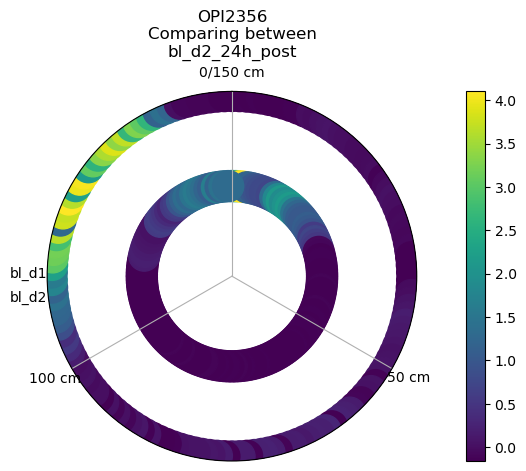

In [131]:
fig = plt.figure()
#plt.title(f'{animal}\nComparing between\n{sessions}')
ax = fig.add_subplot(1,1,1, projection='polar')
ax.set_title(f'{animal}\nComparing between\n{sessions}')
for j,condition in enumerate(conditions[:-1]):
    ax.set_theta_direction(-1)  # Set clockwise direction
    ax.set_theta_zero_location('N')  # Set zero angle at North
    sessions=f'{condition}_{conditions[j+1]}'
    event_radii = np.ones_like(theta) * (j + 1)
    cyclic_data=fr_rate_maps_to_compare_indexed[sessions][j].iloc[0]
    # Customize the tick labels on the circles (bins)
    circle_ticks = [0, 120, 240]  # Tick positions in degrees
    circle_labels = ['0/150 cm', '50 cm', '100 cm']  # Labels for the ticks
    ax.set_xticks(np.radians(circle_ticks))  # Set the tick positions in radians
    ax.set_xticklabels(circle_labels)


    # Plot the firing rate map as colored points along the edge of the circle
    sc = ax.scatter(theta, event_radii, c=cyclic_data, cmap='viridis', s=500, edgecolors='face')

    # Annotate the conditions outside the subplot
    #fig.text(0.1, 0.5 - j * 0.05, condition, horizontalalignment='center', verticalalignment='center')



# Add a color bar
ax.yaxis.set_visible(False)
plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.1)

plt.show()


In [96]:
fr_rate_maps_to_compare[sessions][2]

IndexError: list index out of range

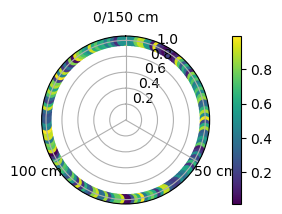

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize the circle with 150 bins
theta = np.linspace(0, 2*np.pi, 150, endpoint=False)

# Example firing rate map
cyclic_data = np.random.rand(150)  # Replace with your actual firing rate map

# Create the polar plot
fig = plt.figure()
ax = fig.add_subplot(2, 2, 3, projection='polar')
ax.set_theta_direction(-1)  # Set clockwise direction
ax.set_theta_zero_location('N')  # Set zero angle at North

# Customize the tick labels on the circles (bins)
circle_ticks = [0, 120, 240]  # Tick positions in degrees
circle_labels = ['0/150 cm', '50 cm', '100 cm']  # Labels for the ticks
ax.set_xticks(np.radians(circle_ticks))  # Set the tick positions in radians
ax.set_xticklabels(circle_labels)

# Plot the firing rate map as colored points along the edge of the circle
sc = ax.scatter(theta, np.ones_like(theta), c=cyclic_data, cmap='viridis', s=50, edgecolors='face')

# Add a color bar
plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.1)

plt.show()